In [70]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.calibration import calibration_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN  # Changed from SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# Load data
df = pd.read_csv("credit_risk_dataset.csv")

# Check for missing values
print("Missing Values:\n", df.isnull().sum())

# Feature engineering: Add debt-to-income ratio
df["debt_to_income"] = df["loan_amnt"] / df["person_income"]
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)

# Define features and target
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Missing Values:
 person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


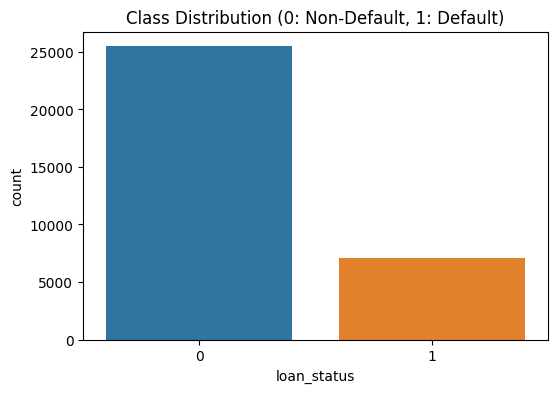

In [71]:
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=df)
plt.title("Class Distribution (0: Non-Default, 1: Default)")
plt.savefig('class_distribution.png', dpi=300)
plt.show()

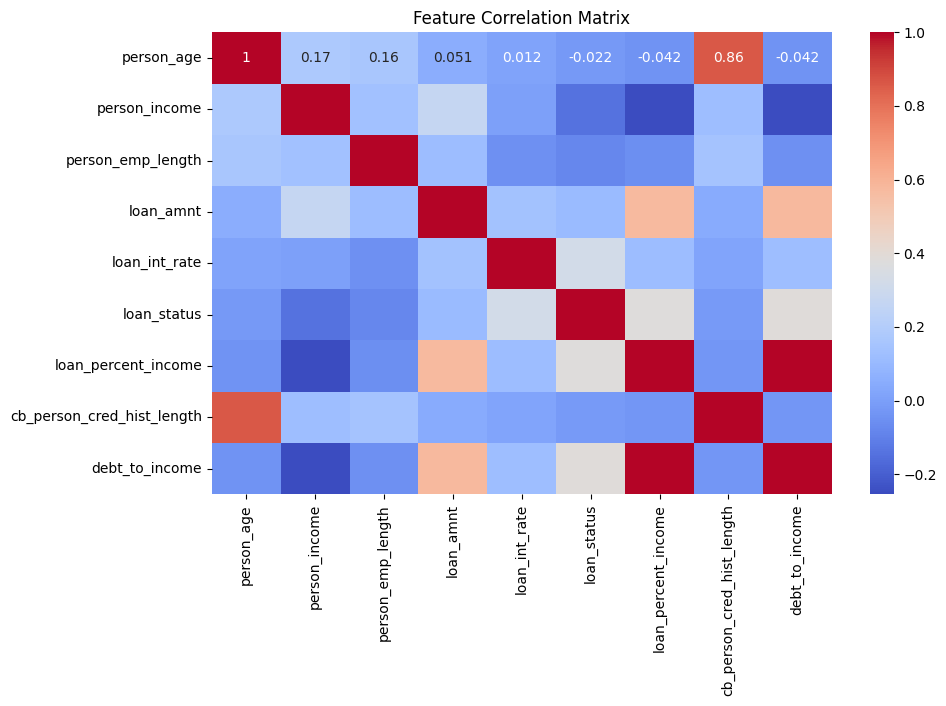

In [72]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()

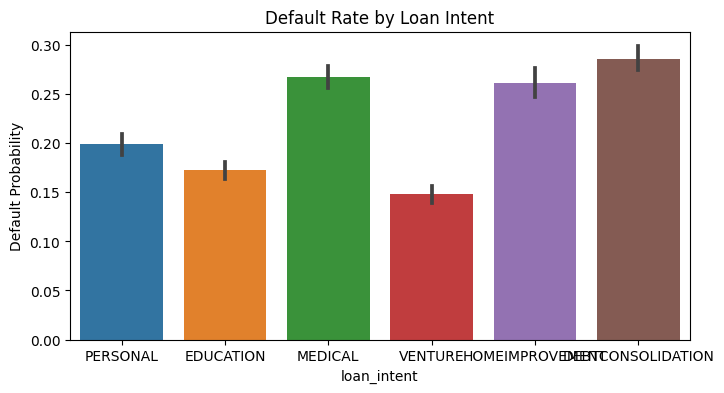

In [73]:
plt.figure(figsize=(8, 4))
sns.barplot(x='loan_intent', y='loan_status', data=df, estimator=np.mean)
plt.title("Default Rate by Loan Intent")
plt.ylabel("Default Probability")
plt.savefig('loan_intent_vs_default.png', dpi=300)
plt.show()

In [45]:
# Preprocessing
num_cols = [
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_amnt",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_cred_hist_length",
    "debt_to_income",  # New feature
]
cat_cols = [
    "person_home_ownership",
    "loan_intent",
    "loan_grade",
    "cb_person_default_on_file",
]

In [46]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            ),
            num_cols,
        ),
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("encoder", OneHotEncoder(handle_unknown="ignore")),
                ]
            ),
            cat_cols,
        ),
    ]
)

In [47]:
# ===========================================
# Model 1: Cost-Sensitive Logistic Regression
# ===========================================

lr_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("sampler", ADASYN(random_state=42)),  # More sophisticated resampling
        (
            "classifier",
            LogisticRegression(
                class_weight={0: 1, 1: 3},  # Higher weight for Default class
                solver="liblinear",
                max_iter=1000,
            ),
        ),
    ]
)

c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


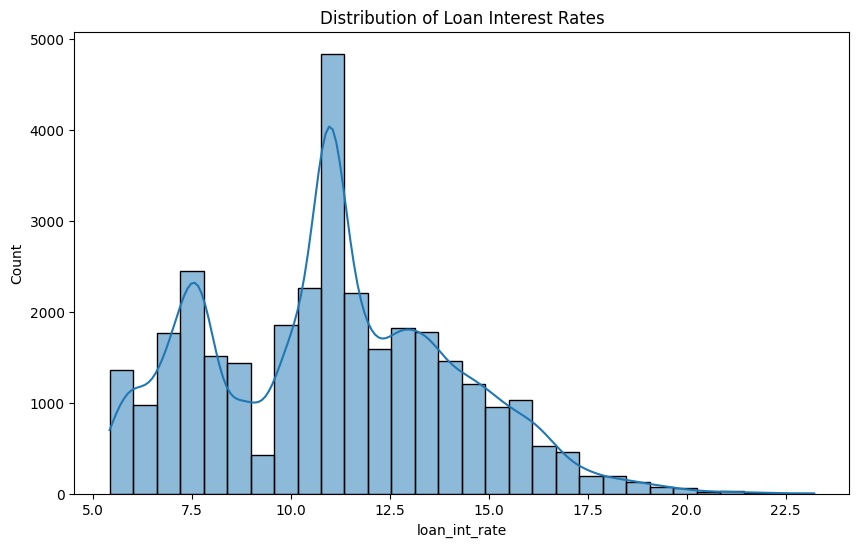

In [74]:
plt.figure(figsize=(10, 6))
sns.histplot(df['loan_int_rate'], kde=True, bins=30)
plt.title("Distribution of Loan Interest Rates")
plt.savefig('loan_int_rate_dist.png', dpi=300)
plt.show()

In [48]:
# ===========================================
# Model 2: XGBoost with Class Balancing
# ===========================================
xgb_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            XGBClassifier(
                scale_pos_weight=np.sum(y == 0) / np.sum(y == 1),  # Auto-balance
                eval_metric="logloss",
                use_label_encoder=False,
            ),
        ),
    ]
)


In [51]:
from sklearn.metrics import (
    precision_recall_curve,
    PrecisionRecallDisplay,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
# ===========================================
# Model Comparison & Threshold Tuning
# ===========================================
models = {
    "Logistic Regression (Cost-Sensitive)": lr_pipeline,
    "XGBoost (Balanced)": xgb_pipeline,
}

results = {}
for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Get probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Find optimal threshold (maximizes F1 for Default class)
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Apply threshold
    y_pred = (y_proba >= optimal_threshold).astype(int)
    
    # Store results
    results[name] = {
        "model": model,
        "threshold": optimal_threshold,
        "report": classification_report(y_test, y_pred, output_dict=True),
        "proba": y_proba,
    }


<Figure size 1000x600 with 0 Axes>

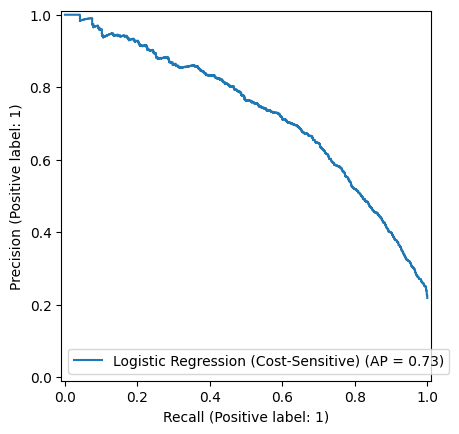

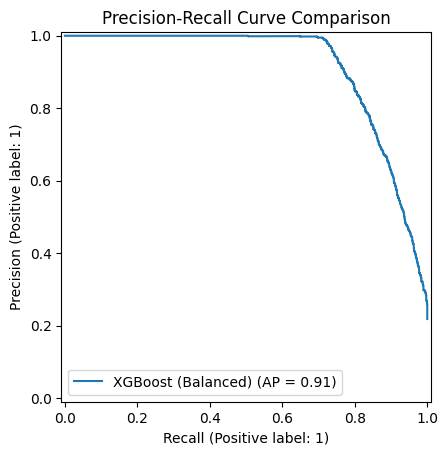

In [52]:
from sklearn.metrics import (
    precision_recall_curve,
    PrecisionRecallDisplay,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# ===========================================
# Visualization: Precision-Recall Tradeoff
# ===========================================
plt.figure(figsize=(10, 6))
for name, res in results.items():
    PrecisionRecallDisplay.from_predictions(y_test, res["proba"], name=name)
plt.title("Precision-Recall Curve Comparison")
plt.savefig("precision_recall_curve.png", dpi=300)
plt.show()


In [53]:
# ===========================================
# Best Model Selection & Analysis
# ===========================================
# Compare metrics
metrics = []
for name, res in results.items():
    metrics.append({
        "Model": name,
        "Default Precision": res["report"]["1"]["precision"],
        "Default Recall": res["report"]["1"]["recall"],
        "Default F1": res["report"]["1"]["f1-score"],
        "Threshold": res["threshold"],
    })

metrics_df = pd.DataFrame(metrics)
print("\nModel Comparison:")
print(metrics_df.to_markdown(index=False))

# Save best model (XGBoost example)
best_model = results["XGBoost (Balanced)"]["model"]
joblib.dump(best_model, "improved_credit_model.pkl")


Model Comparison:
| Model                                |   Default Precision |   Default Recall |   Default F1 |   Threshold |
|:-------------------------------------|--------------------:|-----------------:|-------------:|------------:|
| Logistic Regression (Cost-Sensitive) |            0.664613 |         0.682841 |     0.673604 |    0.863218 |
| XGBoost (Balanced)                   |            0.965899 |         0.73699  |     0.836059 |    0.737493 |


['improved_credit_model.pkl']

In [ ]:
# ===========================================
# Threshold Sensitivity Analysis
# ===========================================

from sklearn.metrics import f1_score

f1_scores = [f1_score(y_test, (y_proba >= t).astype(int)) for t in thresholds]
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold: {best_thresh:.2f}")


Optimal Threshold: 0.70


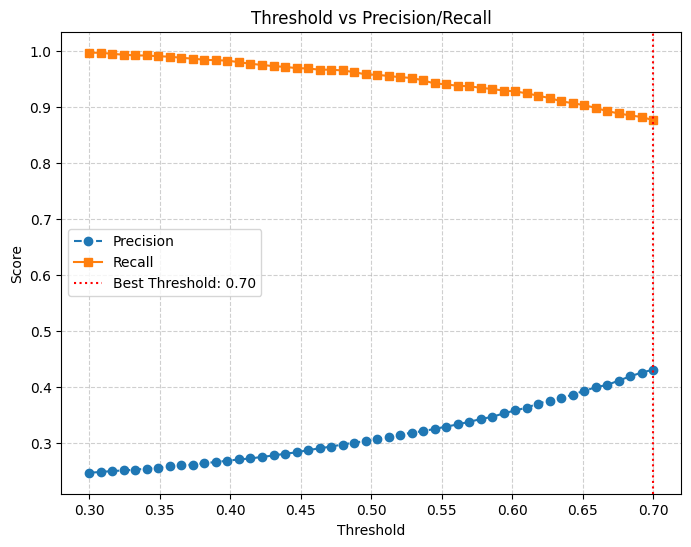

In [61]:
from sklearn.metrics import precision_score, recall_score


plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label="Precision", linestyle="--", marker="o")
plt.plot(thresholds, recalls, label="Recall", linestyle="-", marker="s")
plt.axvline(x=best_thresh, color="red", linestyle="dotted", label=f"Best Threshold: {best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision/Recall")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("threshold_analysis.png", dpi=300)
plt.show()


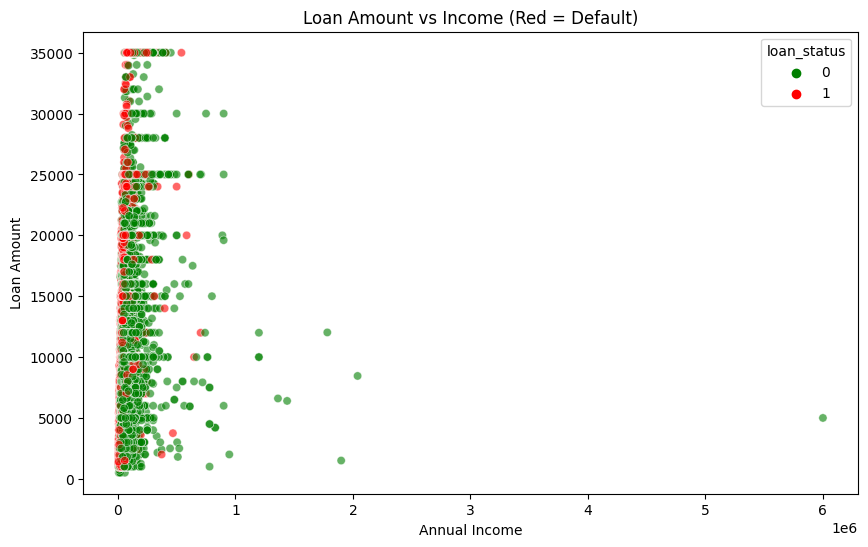

In [65]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="person_income",
    y="loan_amnt",
    hue="loan_status",
    data=df,
    alpha=0.6,
    palette={0: "green", 1: "red"}
)
plt.xlabel("Annual Income")
plt.ylabel("Loan Amount")
plt.title("Loan Amount vs Income (Red = Default)")
plt.savefig("loan_vs_income.png", dpi=300)
plt.show()

c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


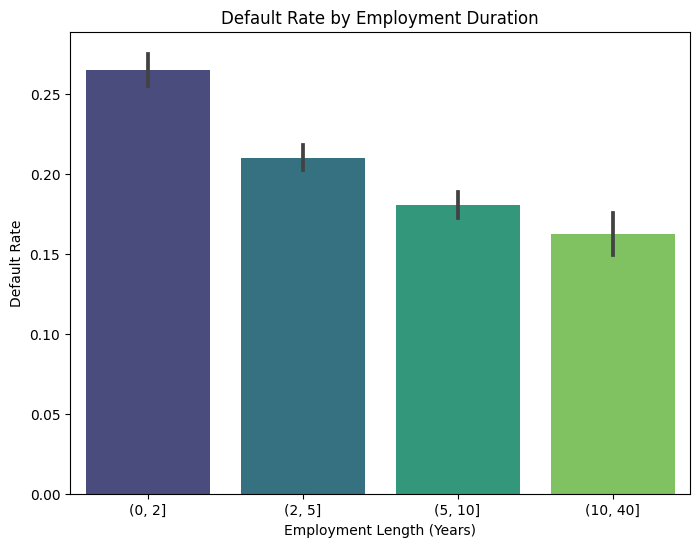

In [67]:
plt.figure(figsize=(8, 6))
sns.barplot(
    x=pd.cut(df["person_emp_length"], bins=[0, 2, 5, 10, 40]),
    y="loan_status",
    data=df,
    estimator=np.mean,
    palette="viridis"
)
plt.xlabel("Employment Length (Years)")
plt.ylabel("Default Rate")
plt.title("Default Rate by Employment Duration")
plt.savefig("default_vs_employment.png", dpi=300)
plt.show()

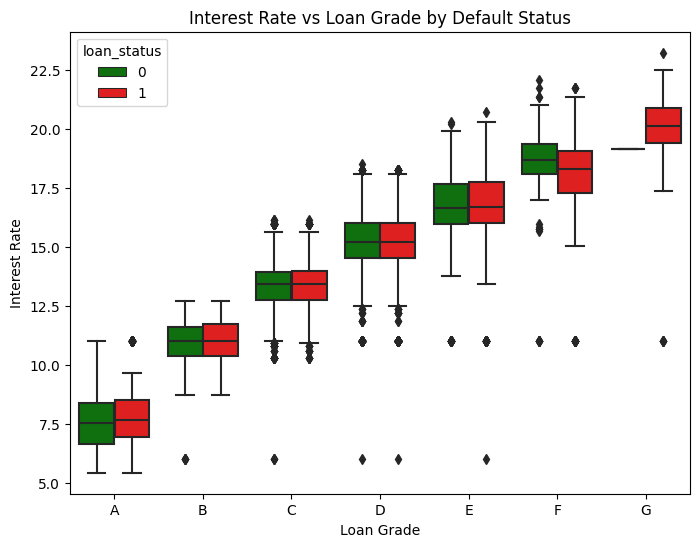

In [68]:
grade_order = sorted(df["loan_grade"].unique())
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="loan_grade",
    y="loan_int_rate",
    hue="loan_status",
    data=df,
    order=grade_order,
    palette={0: "green", 1: "red"}
)
plt.xlabel("Loan Grade")
plt.ylabel("Interest Rate")
plt.title("Interest Rate vs Loan Grade by Default Status")
plt.savefig("grade_risk_analysis.png", dpi=300)
plt.show()